# **Sentiment Analysis of Netflix's Squid Game Tweets**

To be a global leader in entertainment business, Netflix can make use of sentiment analysis using Long Short-Term Memory (LSTM), Simple Recurrent Neural Network (SimpleRNN), Gated Recurrent Units(GRU) and Bidirectional LSTM models to develop better insights about customer preferences thereby gaining competitive advantage and increase their brand value.

## Data Collection and Preparation

The data for this application was obtained from the Kaggle.com website. The primary information came from: https://www.kaggle.com/deepcontractor/squid-game-netflix-twitter-data
This dataset has over 80,000 Tweets and 12 columns

In [117]:
#Mount Drive to the colab notebook 
from google.colab import drive
drive.mount('/content/drive')
#from google.colab import drive
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
#Importing all necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, regexp_tokenize
import string
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from matplotlib import cm
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
#import necessary keras packages
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D, TimeDistributed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence
import pickle

In [119]:
#Data Preparation
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/squid_game.csv")
print(data.head())
data = data.drop(columns="user_name", axis=1)
data = data.drop(columns="user_location", axis=1)
data = data.drop(columns="user_description", axis=1)
data = data.drop(columns="user_created", axis=1)
data = data.drop(columns="user_followers", axis=1)
data = data.drop(columns="user_friends", axis=1)
data = data.drop(columns="user_favourites", axis=1)
data = data.drop(columns="user_verified", axis=1)
data = data.drop(columns="date", axis=1)
data = data.drop(columns="source", axis=1)
data = data.drop(columns="is_retweet", axis=1)
print(data.isnull().sum())
data = data.dropna()
print(data.isnull().sum())

                    user_name  user_location  ...               source is_retweet
0   the _ûndër-ratèd niggáh👊🏾            NaN  ...  Twitter for Android      False
1  Best uncle on planet earth            NaN  ...  Twitter for Android      False
2                      marcie            NaN  ...      Twitter Web App      False
3                    YoMo.Mdp  Any pronouns   ...      Twitter Web App      False
4             Laura Reactions         France  ...      Twitter Web App      False

[5 rows x 12 columns]
text    0
dtype: int64
text    0
dtype: int64


In [120]:
# filtering duplicates
duplicates = data[data['text'].duplicated()]

#Check if there are duplicates present in the dataset.
if (len(duplicates)>0):
#Dropping the duplicates
  data.drop_duplicates(subset='text',inplace=True)
  print(len(duplicates), "duplicates dropped")

4838 duplicates dropped


In [121]:
#Cleaning the text data
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["text"] = data["text"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Creation of Word Cloud

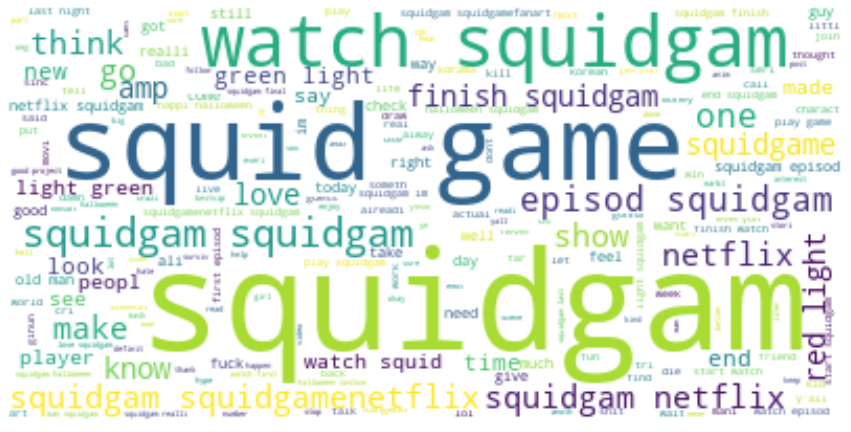

In [122]:
#Creating a word cloud based on the cleansed text
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Polarity Scores for Input Tweets

In [123]:
#Find the sentiment polarity scores for text data using nltk
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data["Sentiment_Polarity"] = [sentiments.polarity_scores(i)["compound"] for i in data["text"]]
print(data.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
                                                text  Sentiment_Polarity
0  life hit time poverti strike yougong yoo  let ...              0.2263
1                    marbl episod squidgam  ruin 😭😭😭             -0.5859
2                                      squidgam time              0.0000
3  blood  slideim join squidgam thing im alreadi ...             -0.4767
4  two first game player kill mask guy  bloodi ni...             -0.8860


### Sentiment Identification based on the polarity scores

Threshold values are set for classifying sentences as either positive, neutral, or negative. 

Threshold values are:

positive sentiment : (compound score >= 0.05) 

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)


In [124]:
#Identify the emotion of the text based on the sentiment polarity scores
data['Emotion'] = np.where((data.Sentiment_Polarity >= 0.05), "Positive", np.where((data.Sentiment_Polarity <= -0.05), "Negative","Neutral"))
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment_Analysis_1.csv')
print(data.head(100))

                                                 text  ...   Emotion
0   life hit time poverti strike yougong yoo  let ...  ...  Positive
1                     marbl episod squidgam  ruin 😭😭😭  ...  Negative
2                                       squidgam time  ...   Neutral
3   blood  slideim join squidgam thing im alreadi ...  ...  Negative
4   two first game player kill mask guy  bloodi ni...  ...  Negative
..                                                ...  ...       ...
95  contribut squidgam thing virgin hungri game co...  ...   Neutral
96  joohoney pull monsta xray tracksuit storage😆of...  ...   Neutral
97  guy squidgam 👏🏻👏🏻 definet bing watch act well ...  ...  Positive
98         mannn blokkkkkoalasarecom huglif squidgam   ...   Neutral
99  give pollut red light give emissionfre blusmar...  ...   Neutral

[100 rows x 3 columns]


In [125]:
data.shape

(75181, 3)

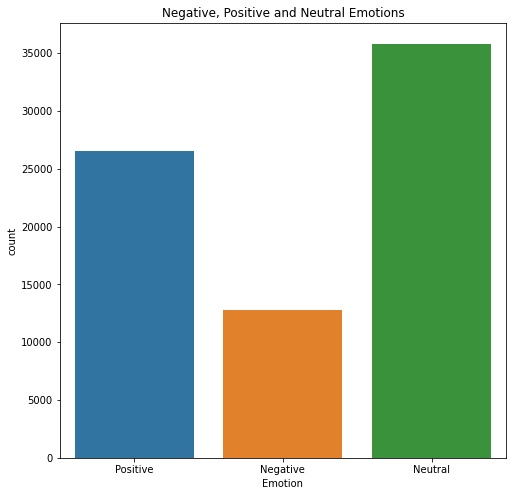

In [126]:
#counterplot of emotion
plt.figure(figsize=(8,8))
sns.countplot(x="Emotion", data=data)
plt.title('Negative, Positive and Neutral Emotions')
plt.show()


In [127]:
#differentiating three different emotions 
print("Given Dataframe :\n", data) 
data_negative = data[data['Emotion'] == 'Negative']
data_neutral = data[data['Emotion'] == 'Neutral']
data_positive = data[data['Emotion'] == 'Positive']

Given Dataframe :
                                                     text  ...   Emotion
0      life hit time poverti strike yougong yoo  let ...  ...  Positive
1                        marbl episod squidgam  ruin 😭😭😭  ...  Negative
2                                          squidgam time  ...   Neutral
3      blood  slideim join squidgam thing im alreadi ...  ...  Negative
4      two first game player kill mask guy  bloodi ni...  ...  Negative
...                                                  ...  ...       ...
80014  yes yes yesarianagrandesquidgam  outerwear pro...  ...  Positive
80015  squid game review revaaa squidgam review anyth...  ...   Neutral
80016  back amp forth squid game creator amp lebron j...  ...   Neutral
80017  sort game think theyll play inevit make squidg...  ...  Positive
80018  venanciotaylor tracklist cala boca swifter gfv...  ...   Neutral

[75181 rows x 3 columns]


In [128]:
print(data_negative)
print(data_positive)
print(data_neutral)

                                                    text  ...   Emotion
1                        marbl episod squidgam  ruin 😭😭😭  ...  Negative
3      blood  slideim join squidgam thing im alreadi ...  ...  Negative
4      two first game player kill mask guy  bloodi ni...  ...  Negative
6      bhundredhyun pls use gun 😩 baekhyun exo weareo...  ...  Negative
8      ive seen bilingu korean speaker slam squidgam ...  ...  Negative
...                                                  ...  ...       ...
79949  netflix runaway hit seri squidgam show real pr...  ...  Negative
79950  watch squid game netflix tv seri remind movi s...  ...  Negative
79959  popular halloween costum year wrong answer onl...  ...  Negative
79968  theyr thingpoor peopl sign kill poor peopl ord...  ...  Negative
79977  bad feel run bogumssi run😱🐙🐙🐙hav watch squidga...  ...  Negative

[12784 rows x 3 columns]
                                                    text  ...   Emotion
0      life hit time poverti strike yo

In [129]:
#tweet_text column 
text_negative = data_negative['text']
text_neutral = data_neutral['text']
text_positive = data_positive['text']

In [130]:
#function to process the tweets

def process_tweet(text):
    tw = remove_nonwords(text)
    tokens = nltk.word_tokenize(tw)
    from nltk.corpus import stopwords
    stopwords_list = list(stopwords.words('english'))
    stopwords_list = stopwords_list + list(string.punctuation)
    stopwords_list = stopwords_list + ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', 's', '2']
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [131]:
#fuction to remove the non-words
def remove_nonwords(string):
    return re.sub("[^A-Za-z ]\w*", ' ', string)

In [132]:
import nltk
nltk.download('punkt')
process_negative = list(map(process_tweet, text_negative))
process_neutral = list(map(process_tweet, text_neutral))
process_positive = list(map(process_tweet, text_positive))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [133]:
print("Processed Negative tweets \n", text_negative, "\n")
print("Processed Positive tweets \n" ,text_positive, "\n")

print("Processed Neutral tweets \n" ,text_neutral, "\n")

Processed Negative tweets 
 1                          marbl episod squidgam  ruin 😭😭😭
3        blood  slideim join squidgam thing im alreadi ...
4        two first game player kill mask guy  bloodi ni...
6        bhundredhyun pls use gun 😩 baekhyun exo weareo...
8        ive seen bilingu korean speaker slam squidgam ...
                               ...                        
79949    netflix runaway hit seri squidgam show real pr...
79950    watch squid game netflix tv seri remind movi s...
79959    popular halloween costum year wrong answer onl...
79968    theyr thingpoor peopl sign kill poor peopl ord...
79977    bad feel run bogumssi run😱🐙🐙🐙hav watch squidga...
Name: text, Length: 12784, dtype: object 

Processed Positive tweets 
 0        life hit time poverti strike yougong yoo  let ...
7        pleas vote daili poll thank 😊do think donni va...
19              dalgona candi lover  newprofilep squidgam 
22       talk peopl love😂🤣🤣😂😂😂😂 save mysteri caus red l...
24       finish 

### Frequency Distribution of Tweets 

In [134]:
flat_negative = [item for sublist in process_negative for item in sublist]
flat_neutral = [item for sublist in process_neutral for item in sublist]
flat_positive = [item for sublist in process_positive for item in sublist]

In [135]:
#frequency distribution of tweet 
negative_freq = FreqDist(flat_negative)
neutral_freq = FreqDist(flat_neutral)
positive_freq = FreqDist(flat_positive)

In [136]:
#top 25 most common words in negative emotion
negative_freq.most_common(25)

[('squidgam', 9573),
 ('game', 2553),
 ('squid', 1687),
 ('watch', 1660),
 ('episod', 1258),
 ('fuck', 964),
 ('like', 718),
 ('show', 708),
 ('netflix', 671),
 ('get', 624),
 ('one', 620),
 ('die', 584),
 ('man', 573),
 ('shit', 553),
 ('peopl', 526),
 ('im', 513),
 ('finish', 512),
 ('end', 468),
 ('kill', 449),
 ('go', 442),
 ('got', 430),
 ('damn', 390),
 ('would', 389),
 ('think', 381),
 ('bad', 380)]

In [137]:
#top 25 most common words in Neutral emotion
neutral_freq.most_common(25)

[('squidgam', 26220),
 ('game', 7218),
 ('squid', 6221),
 ('watch', 4074),
 ('netflix', 3309),
 ('episod', 1990),
 ('squidgamenetflix', 1427),
 ('halloween', 1369),
 ('light', 1282),
 ('one', 1205),
 ('show', 1193),
 ('get', 1143),
 ('finish', 1121),
 ('go', 1004),
 ('new', 869),
 ('know', 836),
 ('red', 835),
 ('seri', 806),
 ('think', 781),
 ('squidgamefanart', 750),
 ('see', 728),
 ('time', 712),
 ('make', 685),
 ('first', 683),
 ('start', 683)]

In [138]:
#top 25 most common word in Positive emotion
positive_freq.most_common(25)

[('squidgam', 17251),
 ('game', 5102),
 ('squid', 3767),
 ('like', 3301),
 ('watch', 3168),
 ('project', 2451),
 ('play', 2421),
 ('netflix', 2322),
 ('good', 2131),
 ('love', 1611),
 ('show', 1496),
 ('episod', 1414),
 ('one', 1253),
 ('get', 1214),
 ('want', 1125),
 ('great', 1108),
 ('finish', 1107),
 ('best', 1085),
 ('hope', 1022),
 ('realli', 923),
 ('im', 911),
 ('go', 903),
 ('seri', 845),
 ('gogosquidgam', 845),
 ('light', 838)]

In [139]:
# create counts of negative, neutral and positive with values and words
negative_bar_counts = [x[1] for x in negative_freq.most_common(25)]
negative_bar_words = [x[0] for x in negative_freq.most_common(25)]

neutral_bar_counts = [x[1] for x in neutral_freq.most_common(25)]
neutral_bar_words = [x[0] for x in neutral_freq.most_common(25)]

positive_bar_counts = [x[1] for x in positive_freq.most_common(25)]
positive_bar_words = [x[0] for x in positive_freq.most_common(25)]

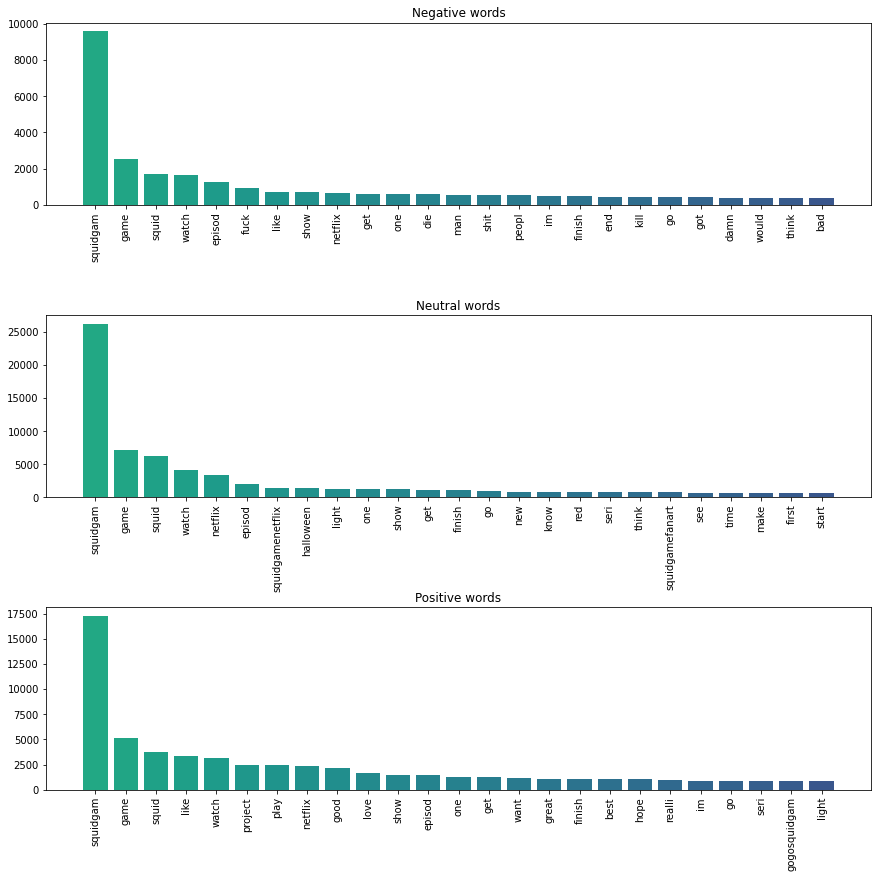

In [140]:
# Plotting negative, positive and neutral words from the tweets
new_figure = plt.figure(figsize=(12,12))
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

ax = new_figure.add_subplot(311)
ax2 = new_figure.add_subplot(312)
ax3 = new_figure.add_subplot(313)

# Generate a line plot on first axes
ax.bar(negative_bar_words, negative_bar_counts, color= color)

# Draw a scatter plot on 2nd axes
ax2.bar(neutral_bar_words, neutral_bar_counts, color=color)

# Draw a scatter plot on 2nd axes
ax3.bar(positive_bar_words, positive_bar_counts, color=color)

ax.title.set_text('Negative words')
ax2.title.set_text('Neutral words')
ax3.title.set_text('Positive words')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.tight_layout(pad=0)
plt.show()

### Creating Data Dictionary for Positive, Negative and Neutral Sentiments

In [141]:
#dictionary for negative, neutral and positive words 
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))
neutral_dictionary = dict(zip(neutral_bar_words, neutral_bar_counts))
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))

In [142]:
# Creating the fuction wordcloud:
def generate_wordcloud(data):
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(data)
    plt.figure(figsize=(10,10),facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

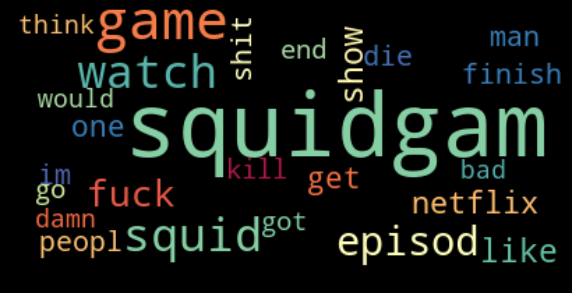

In [143]:
#Generating negative wordcloud
generate_wordcloud(negative_dictionary)

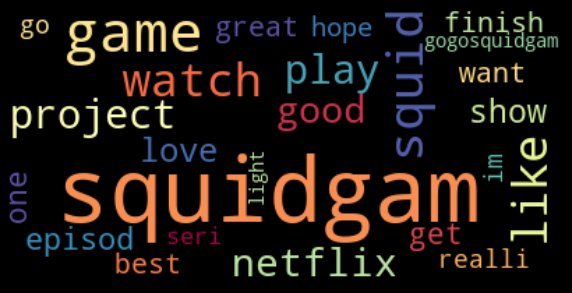

In [144]:
#generating positive wordcloud
generate_wordcloud(positive_dictionary)

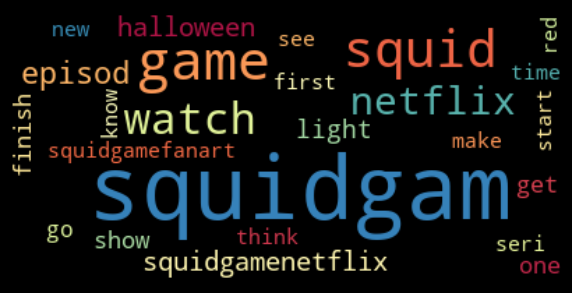

In [145]:
#generating neutral wordcloud
generate_wordcloud(neutral_dictionary)

## Model Creation

In [146]:
#initiate the variables
tweet_input = data['text']
target = data['Emotion']

In [147]:
# applying the function to our data/features 
processed_data = list(map(process_tweet, tweet_input))

In [148]:
#indexing the processed data
pd.Series(processed_data)
processed_data[0]

['life',
 'hit',
 'time',
 'poverti',
 'strike',
 'yougong',
 'yoo',
 'let',
 'play',
 'game',
 'squidgam',
 'netflix']

Lemmatization 

In [149]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
#lemmatization of text
lemmatized_output = []
lemmatizer = WordNetLemmatizer() 
for lists in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in lists])
    lemmatized_output.append(lemmed)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [150]:
#lemmatized output
lemmatized_output[:10]

['life hit time poverti strike yougong yoo let play game squidgam netflix',
 'marbl episod squidgam ruin',
 'squidgam time',
 'blood slideim join squidgam thing im alreadi dead sugar honeycomb ofcsquidgame',
 'two first game player kill mask guy bloodi night third game kill',
 'thggo explod marketcap soonth world first mobathi game anoth levelkardiachain',
 'bhundredhyun pls use gun baekhyun exo weareoneexo squidgam',
 'plea vote daili poll thank think donni van de beek leav manchest unitedy',
 'ive seen bilingu korean speaker slam squidgam translat could feel qualiti write',
 'discov english audio episod squid game korean subtitl im use watch foreign fi']

In [151]:
#initiate X and y
X_lem = lemmatized_output
y_lem = target

In [152]:
# Implement train/test split of dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_lem, y_lem, test_size=0.20, random_state=42)

In [153]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer()
# Fit the vectorizer
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [154]:
from nltk import FreqDist, regexp_tokenize
# Pattern to capture words with apostrophes as one token
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# Casting tweet_text to string or the tokenization doesn't work
data['text'] = data['text'].astype('str')

# Tokenizing tweets and inserting into data
data['raw_tokens'] = data['text'].map(lambda x: regexp_tokenize(x, pattern))

# Lowercase all tokens
data['raw_tokens'] = data['raw_tokens'].map(lambda x: [y.lower() for y in x])

In [155]:
#listing the stop words and creating a column in dataframe
from nltk.corpus import stopwords
stopwords_list = list(stopwords.words('english'))
stopwords_list = stopwords_list + list(string.punctuation)
stopwords_list = stopwords_list + ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', 's', '2']  
data['raw_tokens_stopped'] = data['raw_tokens'].map(lambda x: [y for y in x if y not in stopwords_list])

In [156]:
#tokenize and pad the sequence the tweets
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(data['raw_tokens_stopped']))
list_tokenized = tokenizer.texts_to_sequences(data['raw_tokens_stopped'])
X_values = sequence.pad_sequences(list_tokenized, maxlen=100)

In [157]:
y_values= pd.get_dummies(target).values

In [158]:
# Implement train/test split of dataset
X_train_tk, X_test_tk,y_train_tk,y_test_tk = train_test_split(X_values,y_values,
                                                            test_size=0.20,
                                                            random_state=42)

In [159]:
X_train_tk.shape

(60144, 100)

In [160]:
y_train_tk.shape

(60144, 3)

In [161]:
y_train_tk

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [162]:
with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## RNN Model

In [163]:
#architecture including an embedding layer, RNN layer
embedding_size = 128
model = Sequential()
n = 7120
model.add(Embedding(20000, embedding_size, input_length=100))
model.add(SimpleRNN(48))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())
#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
#checking the summary of the model
model.summary()
#fitting the model on training data with epochs=4
history = model.fit(X_train_tk, y_train_tk, epochs=4, batch_size= 32, validation_split=0.2)
#evaluating the score for train and test data
train_score = model.evaluate(X_train_tk, y_train_tk)
test_score = model.evaluate(X_test_tk, y_test_tk)
print('Train score:', train_score)
print('Test Score:', test_score)
model.save("/content/drive/MyDrive/Colab Notebooks/model/best_model_rnn.h5")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 48)                8496      
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_18 (Dense)            (None, 50)                2450      
                                                                 
 dense_19 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,571,099
Trainable params: 2,571,099
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_13"
_______________

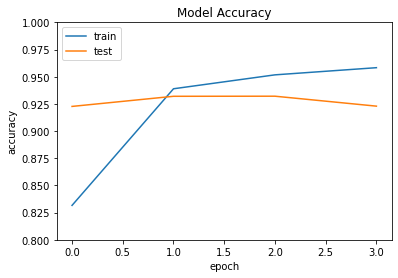

[0.4585719108581543, 0.2064685970544815, 0.1618727296590805, 0.13956356048583984]


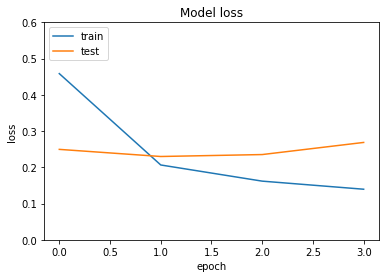

In [164]:
#plotting the Accuracy between training and test sets
#import matplotlib.pyplot as plt
plt.ylim(0.8,1.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#plotting the loss between training and test sets
print(history.history['loss'])
plt.ylim(0,0.6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## GRU Model

In [165]:
#architecture including an embedding layer, GRU layer
embedding_size = 128
model = Sequential()
n = 7120
model.add(Embedding(20000, embedding_size, input_length=100))
model.add(GRU(48))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())
#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
#checking the summary of the model
model.summary()
#fitting the model on training data with epochs=4
history = model.fit(X_train_tk, y_train_tk, epochs=4, batch_size= 32, validation_split=0.2)
#evaluating the score for train and test data
train_score = model.evaluate(X_train_tk, y_train_tk)
test_score = model.evaluate(X_test_tk, y_test_tk)
print('Train score:', train_score)
print('Test Score:', test_score)
model.save("/content/drive/MyDrive/Colab Notebooks/model/best_model_gru.h5")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 gru_10 (GRU)                (None, 48)                25632     
                                                                 
 dropout_6 (Dropout)         (None, 48)                0         
                                                                 
 dense_20 (Dense)            (None, 50)                2450      
                                                                 
 dense_21 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,588,235
Trainable params: 2,588,235
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_14"
_______________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


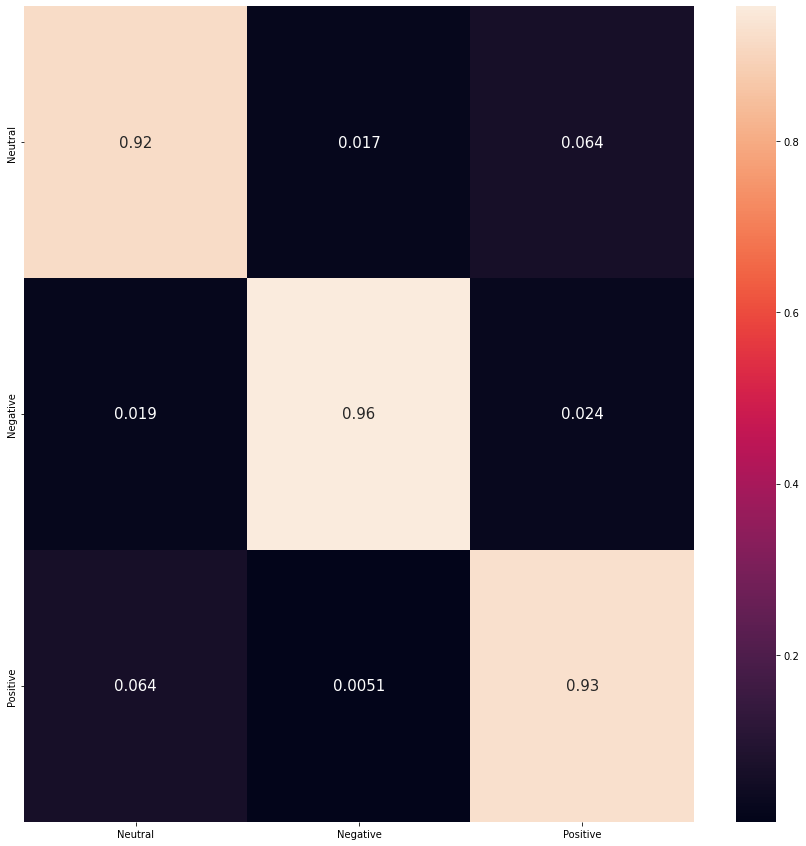

In [166]:
predictions = model.predict(X_test_tk)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_tk.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

From the above’s confusion matrix, we can deduce that:
 

* 93% of positive texts were classified as positive.
* 96% of negative texts were classified as negative.
* 92% of neutral texts were classified as neutral.

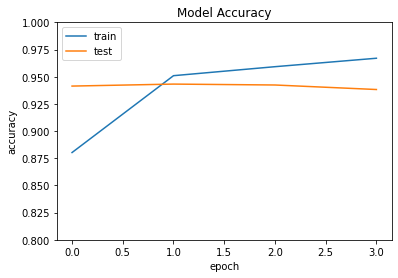

In [167]:
#plotting the Accuracy between training and test sets
#import matplotlib.pyplot as plt
plt.ylim(0.8,1.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

[0.3512292206287384, 0.17006497085094452, 0.13586081564426422, 0.10504668951034546]


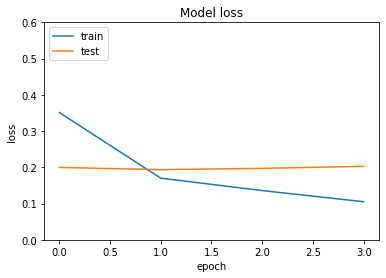

In [168]:
#plotting the loss between training and test sets
print(history.history['loss'])
plt.ylim(0,0.6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## LSTM Model

In [169]:
#architecture including an embedding layer, LSTM layer
embedding_size = 128
model = Sequential()
n = 7120
model.add(Embedding(20000, embedding_size, input_length=100))
model.add(LSTM(48, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 lstm_2 (LSTM)               (None, 48)                33984     
                                                                 
 dropout_7 (Dropout)         (None, 48)                0         
                                                                 
 dense_22 (Dense)            (None, 50)                2450      
                                                                 
 dense_23 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,596,587
Trainable params: 2,596,587
Non-trainable params: 0
_________________________________________________________________
None


In [170]:
#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [171]:
#checking the summary of the model
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 lstm_2 (LSTM)               (None, 48)                33984     
                                                                 
 dropout_7 (Dropout)         (None, 48)                0         
                                                                 
 dense_22 (Dense)            (None, 50)                2450      
                                                                 
 dense_23 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,596,587
Trainable params: 2,596,587
Non-trainable params: 0
_________________________________________________________________


In [172]:
#fitting the model on training data with epochs=4
history = model.fit(X_train_tk, y_train_tk, epochs=4, batch_size= 32, validation_split=0.2)

Epoch 1/4
1504/1504 [==============================] - 136s 89ms/step - loss: 0.3645 - accuracy: 0.8712 - val_loss: 0.2044 - val_accuracy: 0.9401
Epoch 2/4
1504/1504 [==============================] - 134s 89ms/step - loss: 0.1708 - accuracy: 0.9506 - val_loss: 0.2050 - val_accuracy: 0.9377
Epoch 3/4
1504/1504 [==============================] - 134s 89ms/step - loss: 0.1345 - accuracy: 0.9599 - val_loss: 0.2136 - val_accuracy: 0.9366
Epoch 4/4
1504/1504 [==============================] - 135s 90ms/step - loss: 0.1053 - accuracy: 0.9664 - val_loss: 0.2432 - val_accuracy: 0.9329


In [173]:
#evaluating the score for train and test data
train_score = model.evaluate(X_train_tk, y_train_tk)
test_score = model.evaluate(X_test_tk, y_test_tk)
print('Train score:', train_score)
print('Test Score:', test_score)

470/470 [==============================] - 7s 15ms/step - loss: 0.2516 - accuracy: 0.9296
Train score: [0.10780715942382812, 0.9658652544021606]
Test Score: [0.2515840530395508, 0.9295737147331238]


In [174]:
model.save("/content/drive/MyDrive/Colab Notebooks/model/best_model_lstm.h5")

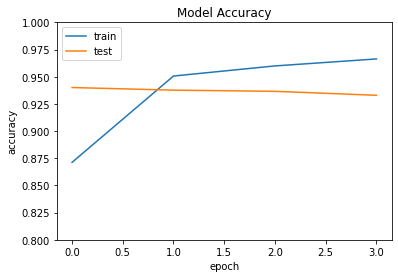

In [175]:
#plotting the Accuracy between training and test sets
#import matplotlib.pyplot as plt
plt.ylim(0.8,1.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

[0.36449289321899414, 0.17081455886363983, 0.13449034094810486, 0.10526182502508163]


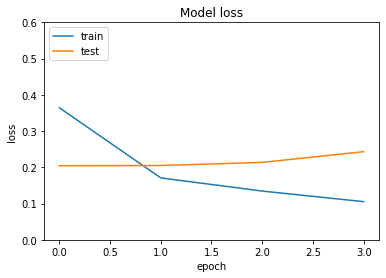

In [176]:
#plotting the loss between training and test sets
print(history.history['loss'])
plt.ylim(0,0.6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Bidirectional LSTM

In [177]:
#architecture including an embedding layer, Bidirectional LSTM layer
#architecture including an embedding layer, LSTM layer
embedding_size = 128
model = Sequential()
n = 7120
model.add(Embedding(20000, embedding_size, input_length=100))
model.add(Bidirectional(LSTM(48, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())

#compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
#checking the summary of the model
model.summary()
#fitting the model on training data with epochs=4
history = model.fit(X_train_tk, y_train_tk, epochs=4, batch_size= 32, validation_split=0.2)
#evaluating the score for train and test data
train_score = model.evaluate(X_train_tk, y_train_tk)
test_score = model.evaluate(X_test_tk, y_test_tk)
print('Train score:', train_score)
print('Test Score:', test_score)
model.save("/content/drive/MyDrive/Colab Notebooks/model/best_model_bi_lstm.h5")

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 96)               67968     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 96)                0         
                                                                 
 dense_24 (Dense)            (None, 50)                4850      
                                                                 
 dense_25 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,632,971
Trainable params: 2,632,971
Non-trainable params: 0
___________________________________________

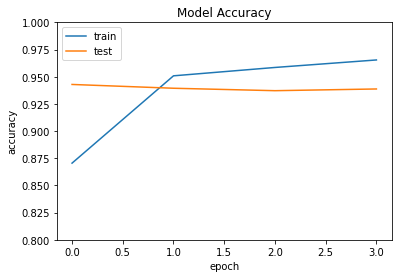

[0.3711964190006256, 0.17204855382442474, 0.13847994804382324, 0.10837504267692566]


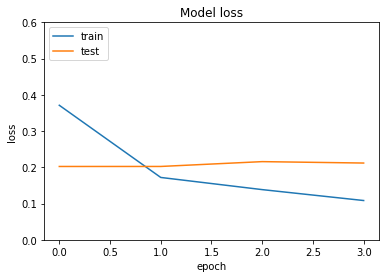

In [178]:
#plotting the Accuracy between training and test sets
#import matplotlib.pyplot as plt
plt.ylim(0.8,1.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#plotting the loss between training and test sets
print(history.history['loss'])
plt.ylim(0,0.6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

85s 56ms/step - loss: 0.1290 - accuracy: 0.9616 - val_loss: 0.2517 - val_accuracy: 0.9307

134s 89ms/step - loss: 0.1060 - accuracy: 0.9662 - val_loss: 0.2129 - val_accuracy: 0.9426

135s 90ms/step - loss: 0.1027 - accuracy: 0.9662 - val_loss: 0.2355 - val_accuracy: 0.9367

210s 139ms/step - loss: 0.1042 - accuracy: 0.9660 - val_loss: 0.2264 - val_accuracy: 0.9373


## Model Comparison

<table>
<tr>
<td>Model Number </td>
<td>Model Description</td>
<td>No of Epochs</td>
<td>Training Accuracy</td>
<td>Validation Accuracy</td>
<td>Training Loss</td>
<td>Validation Loss</td>
<td>Training Time per Epoch</td>
</tr>
<tr>
<td>1 </td>
<td>RNN Model</td>
<td>4</td>
<td>96.16%</td>
<td>93.07%</td>
<td>0.13</td>
<td>0.25</td>
<td>85s</td>
</tr>
<tr>
<td>2 </td>
<td><b>GRU Model</b></td>
<td><b>4</b></td>
<td><b>96.62%<b></td>
<td><b>94.26%<b></td>
<td><b>0.11</b></td>
<td><b>0.21</b></td>
<td><b>134s</b></td>
</tr>
<tr>
<td>3 </td>
<td>LSTM Model</td>
<td>4</td>
<td>96.62%</td>
<td>93.67%</td>
<td>0.10</td>
<td>0.24</td>
<td>135s</td>
</tr>
<tr>
<td>4 </td>
<td>Bidirectional LSTM</td>
<td>4</td>
<td>96.60%</td>
<td>93.73%</td>
<td>0.10</td>
<td>0.23</td>
<td>210s</td>
</tr>
</table>

## Model Prediction

In [179]:
from keras.models import load_model

# Load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/model/best_model_gru.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    cleansed_text = clean(text)
    sentiment_classes = ['Neutral', 'Negative', 'Positive']
    max_len=100
    #tokenize and pad the sequence the tweets
    from tensorflow.python.keras.preprocessing import sequence
    from tensorflow.python.keras.preprocessing import text
    tokenizer = text.Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(list(cleansed_text))
    list_tokenized = tokenizer.texts_to_sequences(cleansed_text)
    X_values = sequence.pad_sequences(list_tokenized, maxlen=100)
    # Do the prediction using the loaded model
    yt = model.predict(X_values).argmax(axis=1)
    sentiment_classes[np.around(model.predict(X_values), decimals=0).argmax(axis=1)[0]]
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [190]:
predict_class("Must watch show best brilliant, fantastic ever ")

The predicted sentiment is Positive


In [181]:
predict_class("#SquidGame honestly sucks, not worth the hype. worse show ever")

The predicted sentiment is Negative


## Model Deployment

In [182]:
!pip install flask gevent requests pillow

In [183]:
procfile = 'web: gunicorn app:app'
procfiles= open("/content/Procfile","w")
procfiles.write(procfile)
procfiles.close()

In [184]:
a = '''
<!doctype html>
<html lang="en">

<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">
<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.1.1/jquery.min.js" type="text/javascript"></script>
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/js/bootstrap.min.js" type="text/javascript"></script>
  <title>Image Recognition Server</title>
  <body class style="margin:10px;padding:10px">
    <img src="https://i.imgur.com/x3JQ0FD.png" alt="Netflix" align="center" width="200" height="80"> 
    <img src="https://thumbs.dreamstime.com/b/red-yellow-green-smileys-emoticons-icon-negative-neutral-positive-different-mood-outline-design-vector-red-yellow-green-146116510.jpg" align="center" width="200" height="80">
    <div class="page-body" id="banner">    
      <form  action="{{ url_for('predict')}}" method="post" enctype=multipart/form-data>
       	<input type="text" name="comment" placeholder="Tweet" required="required" />
        <input type=submit value="Find Sentiment">
    </form>
    </div>
    <p style="margin-bottom:2cm;"></p>
    <div class="row">
        <div class="col-lg-4">
          <div class="page-header">
            <h3 id="tables">Result</h3>
          </div>
          <div class="bs-component">
            <table class="table table-hover">
                <tr class="table-active">
                 
                  <th scope="col">Prediction</th>
                </tr>
                <tr>
                         <td> {{label}} </td>
                  </tr>
            </table> 
        </div>
      </div>
  </body>
  '''

In [185]:
!mkdir '/content/templates'

mkdir: cannot create directory ‘/content/templates’: File exists


In [186]:
Html_file= open("/content/templates/index.html","w")
Html_file.write(a)
Html_file.close()

In [187]:
# function to predict sentiment using nltk model
def sentiment_scores(sentence):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(sentence)
  print("Overall sentiment dictionary is : ", sentiment_dict)
  print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
  print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
  print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
  print("Sentence Overall Rated As", end = " ")

	# decide sentiment as positive, negative and neutral
  if sentiment_dict['compound'] >= 0.05 :
    print("Positive")

  elif sentiment_dict['compound'] <= - 0.05 :
    print("Negative")

  else :
    print("Neutral")

# Driver code
if __name__ == "__main__" :

	print("\n1st statement :")
	sentence = "Must watch show best brilliant  fantastic ever"

	# function calling
	sentiment_scores(sentence)

	print("\n2nd Statement :")
	sentence = "Nothing unusual about the show"
	sentiment_scores(sentence)

	print("\n3rd Statement :")
	sentence = "#SquidGame honestly sucks, not worth the hype. Worse show ever"
	sentiment_scores(sentence)



1st statement :
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.9118}
sentence was rated as  0.0 % Negative
sentence was rated as  25.6 % Neutral
sentence was rated as  74.4 % Positive
Sentence Overall Rated As Positive

2nd Statement :
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Neutral

3rd Statement :
Overall sentiment dictionary is :  {'neg': 0.447, 'neu': 0.369, 'pos': 0.184, 'compound': -0.505}
sentence was rated as  44.7 % Negative
sentence was rated as  36.9 % Neutral
sentence was rated as  18.4 % Positive
Sentence Overall Rated As Negative


In [188]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask
!pip install pyngrok
!ngrok authtoken 21yowOu0EXNnwcASVFH8TC4TNJk_3TdY5stFKCyZ7VSLaxXKX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
import os
import pickle
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
import tensorflow as tf
import numpy as np
import random
import pandas as pd
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import string

app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run



def load_model():
    global tokenizers
    tokenizers = pickle.load(open('/content/tokenizer.pickle', 'rb'))
    global reconstructed_model
    reconstructed_model = models.load_model("/content/drive/MyDrive/Colab Notebooks/model/best_model_gru.h5")

@app.route('/')
def home():
    return render_template('index.html')


def preprocess(train_texts):
    max_len=100
    #tokenize and pad the sequence the tweets
    from tensorflow.python.keras.preprocessing import sequence
    from tensorflow.python.keras.preprocessing import text
    tokenizer = text.Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(list(train_texts))
    list_tokenized = tokenizer.texts_to_sequences(train_texts)
    #print(list_tokenized)
    X_values = sequence.pad_sequences(list_tokenized, maxlen=100)
    #print(X_values)
    return X_values



@app.route('/predict',methods=['POST','GET'])
def predict():

    data = request.form['comment']
    features = [data]
    #print(features)
    listToStr = ' '.join([str(elem) for elem in features])
    #print(listToStr)
    cleansed_text = clean(listToStr)
    #print(cleansed_text)
    final_features = preprocess(cleansed_text)
    prediction = reconstructed_model.predict(final_features).argmax(axis=1)
    #print(prediction)
    if prediction[0] == 0:
      output = "Neutral"
    elif prediction[0] == 1:
      output = "Negative"
    else :
      output = "Positive"
    return render_template('index.html', label='Sentiment is {}'.format(output))



if __name__ == "__main__":
    load_model()
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://de56-34-125-39-74.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Dec/2021 23:14:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Dec/2021 23:14:31] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [08/Dec/2021 23:15:49] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [08/Dec/2021 23:18:19] "POST /predict HTTP/1.1" 200 -
